In [1]:
# import required modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from infrasim.component import Component
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
import numpy as np

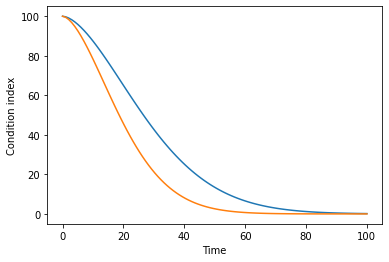

In [2]:
# plot reliability curve

# define the scale and shape parameters
scale = 33.05
shape = 1.68

# scale lower bound and scale upper bound
scale_lower = scale - scale*0.3
scale_upper = scale + scale*0.3

# define the reliability curve for all three shape values
x = np.linspace(0, 100, 100)
y1 = 1 - weibull_min.cdf(x, shape, scale=scale)
y2 = 1 - weibull_min.cdf(x, shape, scale=scale_lower)
y1 = y1*100
y2 = y2*100

# plot the reliability curves
plt.plot(x, y1, label='Reliability Curve')
plt.plot(x, y2, label='Reliability Curve -30%')
plt.xlabel('Time')
plt.ylabel('Condition index')

# given state state s and time t, return the min and max condition indices intersecting with the line x = t
def get_min_max(s, t):

    # define the scale and shape parameters
    scale = 33.05
    shape = 1.68

    # scale lower bound 
    scale_lower = scale - scale*0.3

    # define the reliability curve for alltwo shape values
    x = np.linspace(0, 100, 100)
    y1 = 1 - weibull_min.cdf(x, shape, scale=scale)
    y2 = 1 - weibull_min.cdf(x, shape, scale=scale_lower)
    y1 = y1*100
    y2 = y2*100

    # get the y value at time t
    y1 = int(y1[t])
    y2 = int(y2[t])

    # get every integer between y1 and y2 
    min = y1
    max = y2
    if y1 > y2:
        min = y2
        max = y1
    
    # assign probabilities from s to min, proportional to the distance between s and min
    probs = {}
    for i in range(min, s):
        prob = (s - i)/(s - min)
        probs[i] = prob

    return probs


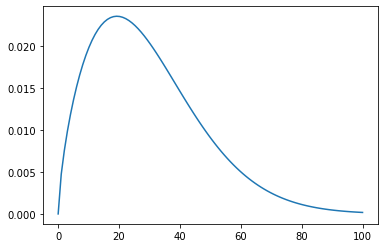

In [3]:
# plot pdf

scale = 33.05
shape = 1.68

x = np.linspace(0, 100, 100)
y = weibull_min.pdf(x, shape, scale=scale)

plt.plot(x, y)

# Defining Component Dynamics

This notebook demonstrates the use of the `Component` class to define the dynamics of a single component. The `Component` class models the condition index (CI) of a component. For or simulations, we define:

- The CI as integer in the range $[0, 100]$ where $100$ represents a perfect component. 
- Actions 0: `no action`, 1: `repair`, 2: `replace`.
- The failure condition (component.failure_condition) as the CI value at which the component fails. 
- An importance score (component.importance_score) that represents the priority of the component. 

The dynamics of the CI are modeled as probabilistic transitions between states, i.e., possible CI values. Specifically, given a condition index $s_t$ at time $t$, the CI of the component at time $t+1$ evolves according to transition probabilities $p(s_{t+1} | s_t, a_t)$, where $a_t$ is the action taken at time $t$. The transition probability distribution here describes both possible next states and the probability of transitioning to each state. We visualize one such transition probability distribution below:

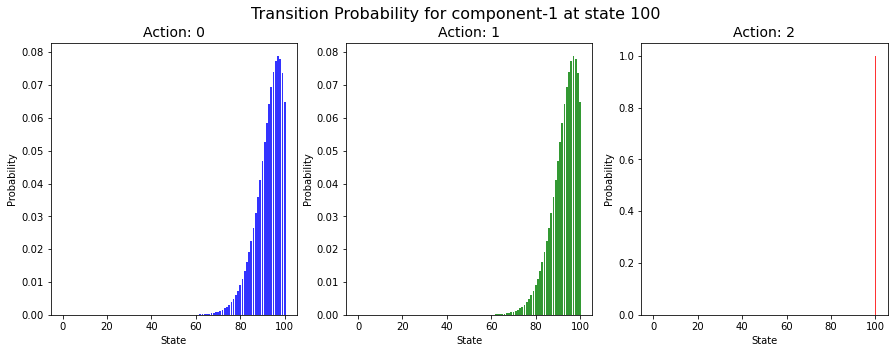

In [2]:
# create a component
component = Component(name='component-1')

# get current state
current_state = 100

# visualize the transition probability matrix for all actions
component.visualize_transition_prob(state=current_state)

As expected, in the case of `no action` and `inspect` actions, the condition index of the component decreases where as in the case of the `repair` action, the condition index increases to the maximum value of 100 (perfect component) with probability 1.

The following figure shows some sample trajectories of the component condition index over time without any intervention to improve component condition. The component condition index starts at 100 (perfect component) and degrades over time. 

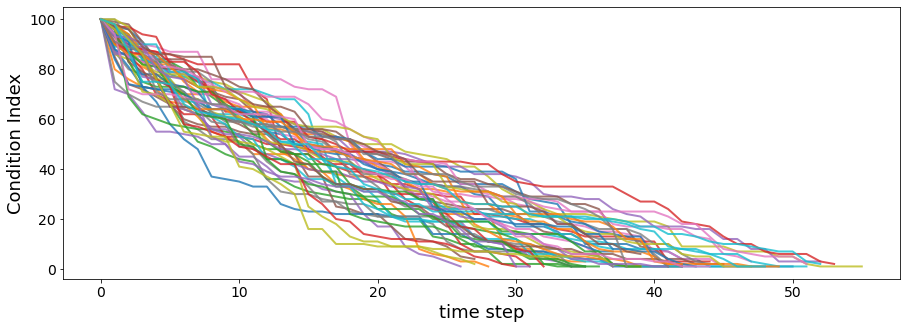

In [3]:
# visualize random trajectory samples
component.visualize_trajectory_samples(num_samples=50)

## Defining the Component Dynamics

The CI dynamics synethesis process is parameterized by the following parameters:

- `dynamics_shape` $\lambda$ with a default value of 1.5
- `dynamics_scale` $\kappa$ with a default value of 10


Note that the dynamics are generated by sampling from the probability density function of a Weibell distribution which can be given as

$$
f(x) = \frac{\lambda}{\kappa} \left(\frac{x}{\kappa}\right)^{\lambda-1} e^{-\left(\frac{x}{\kappa}\right)^\lambda}
$$

where $\lambda$ is the shape parameter and $\kappa$ is the scale parameter. Since the CI only decreases over time without intervention, to synthesize the CI dynamics at any state $s$, we shift the Weibell distribution by $s$ and then sample from the shifted distribution while ignoring the distribution on states that are representing higher CI values than the current state. 

In order to understand the effect of the parameters $\lambda$ and $\kappa$ on the CI dynamics, we plot the transition probabilities and sample trajectories for different values of $\lambda$ and $\kappa$.

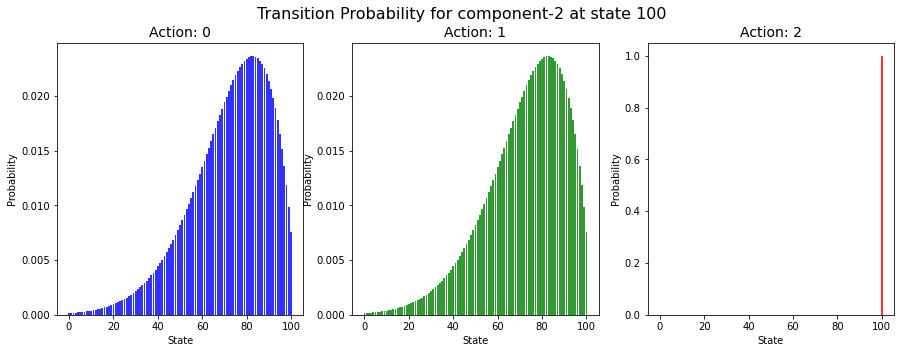

In [4]:
# create a component with larger scale
component = Component(name='component-2', dynamics_scale=33.05, dynamics_shape=1.68)

# visualize the transition probability matrix for all actions
component.visualize_transition_prob(state=100)

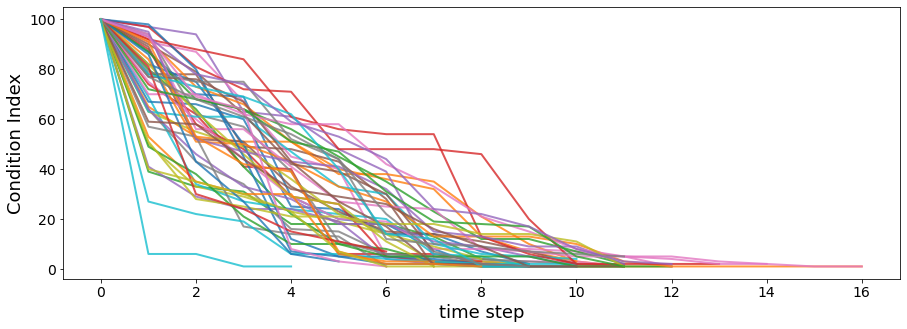

In [5]:
# visualize random trajectory samples
component.visualize_trajectory_samples(num_samples=50)

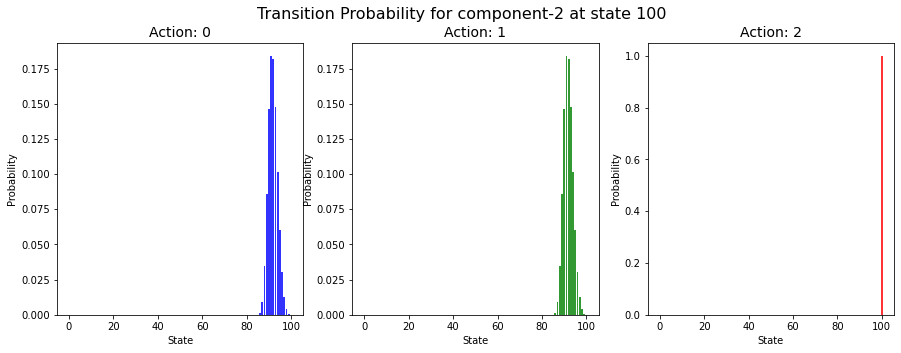

In [12]:
# create a component with larger shape parameter
component = Component(name='component-2', dynamics_scale=10, dynamics_shape=5)

# visualize the transition probability matrix for all actions
component.visualize_transition_prob(state=100)

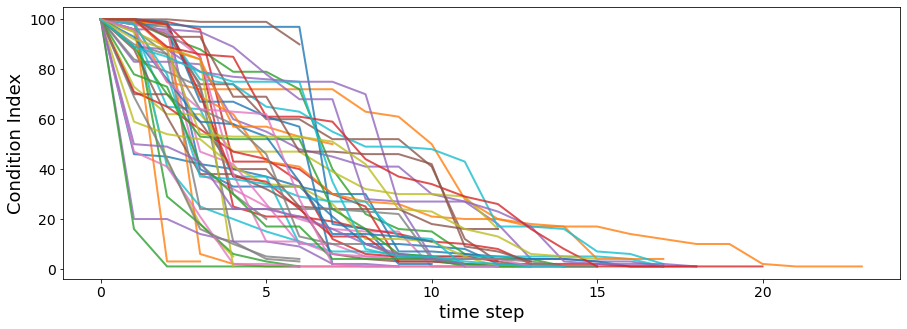

In [17]:
# visualize random trajectory samples
component.visualize_trajectory_samples(num_samples=50)

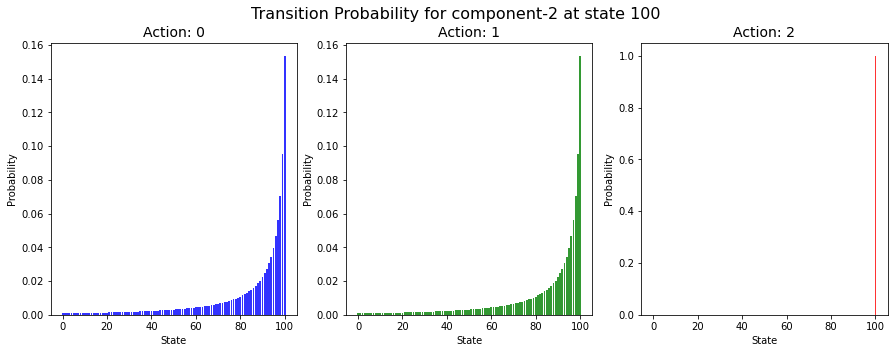

In [14]:
# create a component with smaller shape parameter
component = Component(name='component-2', dynamics_scale=10, dynamics_shape=0.5)

# visualize the transition probability matrix for all actions
component.visualize_transition_prob(state=100)

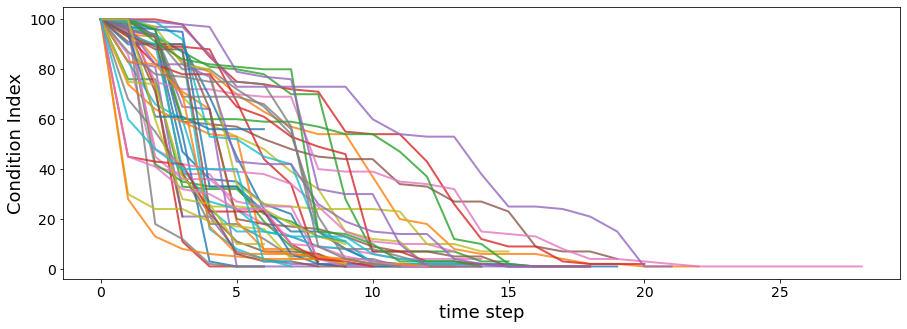

In [15]:
# visualize random trajectory samples
component.visualize_trajectory_samples(num_samples=50)

We notice that increasing the dynamics scale $\kappa$ increases the rate of CI degradation. On the other hand, increasing the dynamics shape $\lambda$ increases the variance of the CI dynamics and the sample trajectories become more erratic. We picked the default values of $\lambda$ and $\kappa$ based to mimic the CI dynamics of a system that has a Weibull-like degradation process. 